# IEEE-CIS Fraud Detection - Classifications

## Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from PIL import Image
from functions.balance_dataset import balance_dataset 
from functions.test_hyperparameters import test_hyperparameters, test_hyperparameters_grid
from functions.create_classifier import create_classifier, plot_confusion_matrix 
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import random

import warnings
warnings.filterwarnings("ignore")

## Config

In [2]:
SEED_VAL = 42
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)

## Read files

In [4]:
# !unzip '../data/train_transaction.zip' -d '../data'

In [5]:
transaction_df = pd.read_csv("../data/train_transaction.csv")

In [ ]:
print(transaction_df.shape)

(590540, 394)


In [5]:
transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing

### Preprocess attributes

All columns

In [6]:
print(transaction_df.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

Remove NaN values

In [7]:
transaction_df = transaction_df.replace(np.nan, 0)

Limit to 5000 samples

In [8]:
transaction_df_samples = transaction_df[:5000]

X_df = transaction_df_samples.drop('isFraud', axis=1)
y_df = transaction_df_samples['isFraud']

Transform categorical attributes on dummy variables

Categorical features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

In [9]:
ProductCD_data = pd.get_dummies(X_df['ProductCD']).add_prefix('ProductCD_')
P_emaildomain_data = pd.get_dummies(X_df['P_emaildomain']).add_prefix('P_emaildomain_')
R_emaildomain_data = pd.get_dummies(X_df['R_emaildomain']).add_prefix('R_emaildomain_')

card1_data = pd.get_dummies(X_df['card1']).add_prefix('card1_')
card2_data = pd.get_dummies(X_df['card2']).add_prefix('card2_')
card3_data = pd.get_dummies(X_df['card3']).add_prefix('card3_')
card4_data = pd.get_dummies(X_df['card4']).add_prefix('card4_')
card5_data = pd.get_dummies(X_df['card5']).add_prefix('card5_')
card6_data = pd.get_dummies(X_df['card6']).add_prefix('card6_')

addr1_data = pd.get_dummies(X_df['addr1']).add_prefix('addr1_')
addr2_data = pd.get_dummies(X_df['addr2']).add_prefix('addr2_')

M1_data = pd.get_dummies(X_df['M1']).add_prefix('M1_')
M2_data = pd.get_dummies(X_df['M2']).add_prefix('M2_')
M3_data = pd.get_dummies(X_df['M3']).add_prefix('M3_')
M4_data = pd.get_dummies(X_df['M4']).add_prefix('M4_')
M5_data = pd.get_dummies(X_df['M5']).add_prefix('M5_')
M6_data = pd.get_dummies(X_df['M6']).add_prefix('M6_')
M7_data = pd.get_dummies(X_df['M7']).add_prefix('M7_')
M8_data = pd.get_dummies(X_df['M8']).add_prefix('M8_')
M9_data = pd.get_dummies(X_df['M9']).add_prefix('M9_')

X_df = X_df[X_df.columns.drop(['TransactionID','ProductCD', 'P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'])]

X_df = pd.concat([X_df, ProductCD_data, P_emaildomain_data, R_emaildomain_data, 
                    card1_data, card2_data, card3_data, card4_data, card5_data, card6_data,
                    addr1_data, addr2_data,
                    M1_data, M2_data, M3_data, M4_data, M5_data, M6_data, M7_data, M8_data, M9_data], join = 'outer', axis=1)


In [10]:
X_df.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,M6_T,M7_0,M7_F,M7_T,M8_0,M8_F,M8_T,M9_0,M9_F,M9_T
0,86400,68.5,19.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1,1,0,0,1,0,0,1,0,0
1,86401,29.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1,1,0,0,1,0,0,1,0,0
2,86469,59.0,287.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,1,0,0,1,0,0,1,0
3,86499,50.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
4,86506,50.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0,1,0,0,1,0,0,1,0,0


In [11]:
X_df.shape

(5000, 2263)

### Split dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=SEED_VAL)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED_VAL)

print('Shape of train dataset', X_train.shape)
print('Shape of validation dataset', X_val.shape)
print('Shape of test dataset', X_test.shape)

Shape of train dataset (3000, 2263)
Shape of validation dataset (1000, 2263)
Shape of test dataset (1000, 2263)


### Balance dataset - choose %

Analyzing the proportion of fraudulent samples:

In [12]:
y_train.value_counts(normalize=True)

0    0.982
1    0.018
Name: isFraud, dtype: float64

The fraudulent samples are approximately 4% of the dataset, so we are dealing with an unbalanced dataset.

Define not balanced dataset

In [13]:
X_train_not_balanced_04 = X_train
y_train_not_balanced_04 = y_train

##### Define balanced dataset using oversampling

In [14]:
X_train_balanced_10, y_train_balanced_10 = balance_dataset('oversampling', X_train, y_train, 0.112) # 10% fraud
X_train_balanced_20, y_train_balanced_20 = balance_dataset('oversampling', X_train, y_train, 0.251) # 20% fraud
X_train_balanced_30, y_train_balanced_30 = balance_dataset('oversampling', X_train, y_train, 0.43)  # 30% fraud
X_train_balanced_40, y_train_balanced_40 = balance_dataset('oversampling', X_train, y_train, 0.667) # 40% fraud
X_train_balanced_50, y_train_balanced_50 = balance_dataset('oversampling', X_train, y_train, 1)     # 50% fraud

print('10%:')
print('X_train.shape', X_train_balanced_10.shape)

print('\n20%:')
print('X_train.shape', X_train_balanced_20.shape)

print('\n30%:')
print('X_train.shape', X_train_balanced_30.shape)

print('\n40%:')
print('X_train.shape', X_train_balanced_40.shape)

print('\n50%:')
print('X_train.shape', X_train_balanced_50.shape)

10%:
X_train.shape (3275, 2263)

20%:
X_train.shape (3685, 2263)

30%:
X_train.shape (4212, 2263)

40%:
X_train.shape (4910, 2263)

50%:
X_train.shape (5892, 2263)


In [20]:
y_train_balanced_50.value_counts(normalize=True)

0    0.5
1    0.5
Name: isFraud, dtype: float64

##### Define balanced dataset using undersampling

In [18]:
X_train_balanced_us_10, y_train_balanced_us_10 = balance_dataset('undersampling', X_train, y_train, 0.112) # 10% fraud
X_train_balanced_us_20, y_train_balanced_us_20 = balance_dataset('undersampling', X_train, y_train, 0.251) # 20% fraud
X_train_balanced_us_30, y_train_balanced_us_30 = balance_dataset('undersampling', X_train, y_train, 0.43)  # 30% fraud
X_train_balanced_us_40, y_train_balanced_us_40 = balance_dataset('undersampling', X_train, y_train, 0.667) # 40% fraud
X_train_balanced_us_50, y_train_balanced_us_50 = balance_dataset('undersampling', X_train, y_train, 1)     # 50% fraud

print('10%:')
print('X_train.shape', X_train_balanced_us_10.shape)

print('\n20%:')
print('X_train.shape', X_train_balanced_us_20.shape)

print('\n30%:')
print('X_train.shape', X_train_balanced_us_30.shape)

print('\n40%:')
print('X_train.shape', X_train_balanced_us_40.shape)

print('\n50%:')
print('X_train.shape', X_train_balanced_us_50.shape)

10%:
X_train.shape (536, 2263)

20%:
X_train.shape (269, 2263)

30%:
X_train.shape (179, 2263)

40%:
X_train.shape (134, 2263)

50%:
X_train.shape (108, 2263)


In [19]:
y_train_balanced_us_50.value_counts(normalize=True)

0    0.5
1    0.5
Name: isFraud, dtype: float64

#### Normalize data for Naive Bayes

In [20]:
scaler = MinMaxScaler()

X_train_not_balanced_04_normalized = scaler.fit(X_train_not_balanced_04).transform(X_train_not_balanced_04)

X_train_balanced_10_normalized = scaler.fit(X_train_balanced_10).transform(X_train_balanced_10)
X_train_balanced_20_normalized = scaler.fit(X_train_balanced_20).transform(X_train_balanced_20)
X_train_balanced_30_normalized = scaler.fit(X_train_balanced_30).transform(X_train_balanced_30)
X_train_balanced_40_normalized = scaler.fit(X_train_balanced_40).transform(X_train_balanced_40)
X_train_balanced_50_normalized = scaler.fit(X_train_balanced_50).transform(X_train_balanced_50)

X_train_balanced_us_10_normalized = scaler.fit(X_train_balanced_us_10).transform(X_train_balanced_us_10)
X_train_balanced_us_20_normalized = scaler.fit(X_train_balanced_us_20).transform(X_train_balanced_us_20)
X_train_balanced_us_30_normalized = scaler.fit(X_train_balanced_us_30).transform(X_train_balanced_us_30)
X_train_balanced_us_40_normalized = scaler.fit(X_train_balanced_us_40).transform(X_train_balanced_us_40)
X_train_balanced_us_50_normalized = scaler.fit(X_train_balanced_us_50).transform(X_train_balanced_us_50)

X_val_normalized = scaler.fit(X_val).transform(X_val)

X_test_normalized = scaler.fit(X_test).transform(X_test)

#### Classification - original data (0.04%)

##### Test hyperparameters

In [24]:
test_hyperparameters('Naive Bayes', X_train_not_balanced_04_normalized, y_train_not_balanced_04)
test_hyperparameters('SVM', X_train_not_balanced_04, y_train_not_balanced_04)
test_hyperparameters('Random Forest', X_train_not_balanced_04, y_train_not_balanced_04)
test_hyperparameters('Multilayer Perceptron', X_train_not_balanced_04, y_train_not_balanced_04)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 1}
Best hyperparameters based on f1 score for SVM: {'kernel': 'poly', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (40,), 'alpha': 1, 'activation': 'relu'}


##### Classificate

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       973
           1       0.06      0.15      0.08        27

    accuracy                           0.91      1000
   macro avg       0.52      0.54      0.52      1000
weighted avg       0.95      0.91      0.93      1000

Confusion Matrix: 


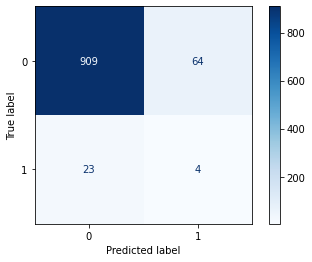

In [25]:
nb_clf = MultinomialNB(alpha=1)

y_pred = create_classifier(nb_clf, X_train_not_balanced_04_normalized, y_train_not_balanced_04, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       973
           1       0.00      0.00      0.00        27

    accuracy                           0.95      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.95      0.95      0.95      1000

Confusion Matrix: 


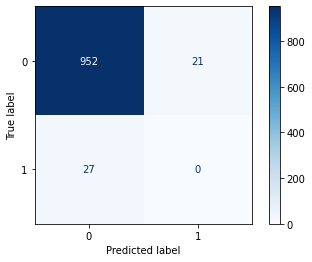

In [26]:
svm_clf = SVC(kernel='sigmoid', C=1000, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_not_balanced_04, y_train_not_balanced_04, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       973
           1       1.00      0.04      0.07        27

    accuracy                           0.97      1000
   macro avg       0.99      0.52      0.53      1000
weighted avg       0.97      0.97      0.96      1000

Confusion Matrix: 


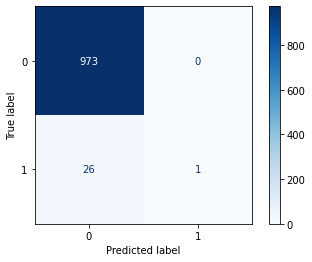

In [27]:
rf_clf = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=40, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_not_balanced_04, y_train_not_balanced_04, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       973
           1       0.50      0.04      0.07        27

    accuracy                           0.97      1000
   macro avg       0.74      0.52      0.53      1000
weighted avg       0.96      0.97      0.96      1000

Confusion Matrix: 


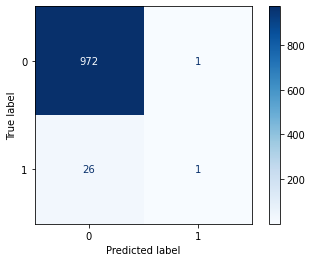

In [28]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(500,), alpha=0.01, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_not_balanced_04, y_train_not_balanced_04, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

#### Classification - oversampling data

##### Test Hyperparameters

PCA unbalanced (10% fraud)

In [29]:
test_hyperparameters('Naive Bayes', X_train_balanced_10_normalized, y_train_balanced_10)
test_hyperparameters('SVM', X_train_balanced_10, y_train_balanced_10)
test_hyperparameters('Random Forest', X_train_balanced_10, y_train_balanced_10)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_10, y_train_balanced_10)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'poly', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'alpha': 0.01, 'activation': 'relu'}


PCA unbalanced (20% fraud)

In [30]:
test_hyperparameters('Naive Bayes', X_train_balanced_20_normalized, y_train_balanced_20)
test_hyperparameters('SVM', X_train_balanced_20, y_train_balanced_20)
test_hyperparameters('Random Forest', X_train_balanced_20, y_train_balanced_20)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_20, y_train_balanced_20)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'poly', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (300,), 'alpha': 1, 'activation': 'tanh'}


PCA unbalanced (30% fraud)

In [31]:
test_hyperparameters('Naive Bayes', X_train_balanced_30_normalized, y_train_balanced_30)
test_hyperparameters('SVM', X_train_balanced_30, y_train_balanced_30)
test_hyperparameters('Random Forest', X_train_balanced_30, y_train_balanced_30)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_30, y_train_balanced_30)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'rbf', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'entropy'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}


PCA unbalanced (40% fraud)

In [32]:
test_hyperparameters('Naive Bayes', X_train_balanced_40_normalized, y_train_balanced_40)
test_hyperparameters('SVM', X_train_balanced_40, y_train_balanced_40)
test_hyperparameters('Random Forest', X_train_balanced_40, y_train_balanced_40)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_40, y_train_balanced_40)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'rbf', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (500,), 'alpha': 0.01, 'activation': 'relu'}


PCA unbalanced (50% fraud)

In [33]:
test_hyperparameters('Naive Bayes', X_train_balanced_50_normalized, y_train_balanced_50)
test_hyperparameters('SVM', X_train_balanced_50, y_train_balanced_50)
test_hyperparameters('Random Forest', X_train_balanced_50, y_train_balanced_50)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_50, y_train_balanced_50)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'rbf', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (300,), 'alpha': 0.001, 'activation': 'relu'}


##### Classificate (10% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       973
           1       0.18      0.56      0.27        27

    accuracy                           0.92      1000
   macro avg       0.58      0.74      0.62      1000
weighted avg       0.97      0.92      0.94      1000

Confusion Matrix: 


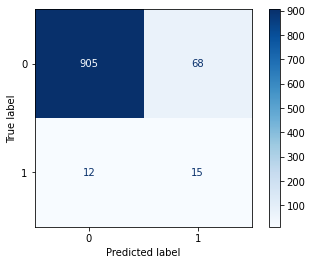

In [34]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_10_normalized, y_train_balanced_10, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       973
           1       0.08      0.33      0.13        27

    accuracy                           0.88      1000
   macro avg       0.53      0.61      0.53      1000
weighted avg       0.96      0.88      0.91      1000

Confusion Matrix: 


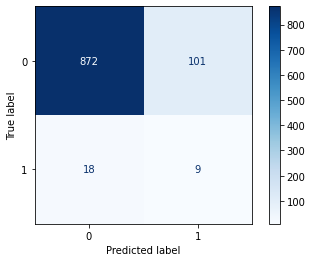

In [35]:
svm_clf = SVC(kernel='sigmoid', C=100, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_10, y_train_balanced_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       973
           1       1.00      0.15      0.26        27

    accuracy                           0.98      1000
   macro avg       0.99      0.57      0.62      1000
weighted avg       0.98      0.98      0.97      1000

Confusion Matrix: 


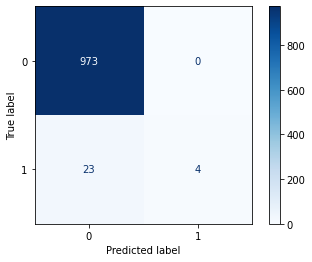

In [36]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=20, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_10, y_train_balanced_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       973
           1       0.30      0.11      0.16        27

    accuracy                           0.97      1000
   macro avg       0.64      0.55      0.57      1000
weighted avg       0.96      0.97      0.96      1000

Confusion Matrix: 


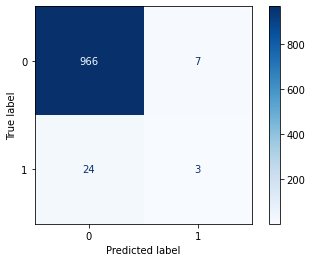

In [37]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(500,), alpha=0.01, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_10, y_train_balanced_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (20% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       973
           1       0.17      0.56      0.27        27

    accuracy                           0.92      1000
   macro avg       0.58      0.74      0.61      1000
weighted avg       0.96      0.92      0.94      1000

Confusion Matrix: 


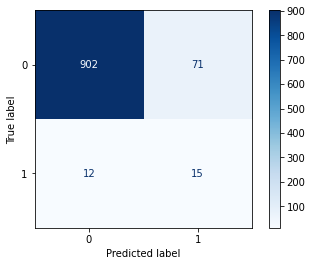

In [38]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_20_normalized, y_train_balanced_20, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       973
           1       0.02      0.15      0.04        27

    accuracy                           0.80      1000
   macro avg       0.50      0.48      0.46      1000
weighted avg       0.95      0.80      0.87      1000

Confusion Matrix: 


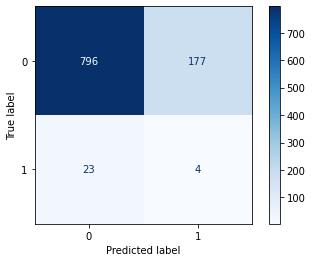

In [39]:
svm_clf = SVC(kernel='sigmoid', C=10, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_20, y_train_balanced_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       973
           1       1.00      0.22      0.36        27

    accuracy                           0.98      1000
   macro avg       0.99      0.61      0.68      1000
weighted avg       0.98      0.98      0.97      1000

Confusion Matrix: 


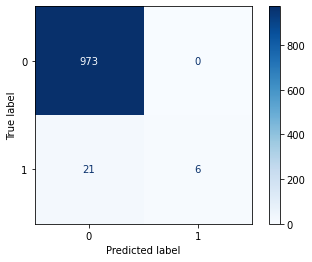

In [40]:
rf_clf = RandomForestClassifier(n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=40, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_20, y_train_balanced_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       973
           1       0.21      0.26      0.23        27

    accuracy                           0.95      1000
   macro avg       0.60      0.62      0.60      1000
weighted avg       0.96      0.95      0.96      1000

Confusion Matrix: 


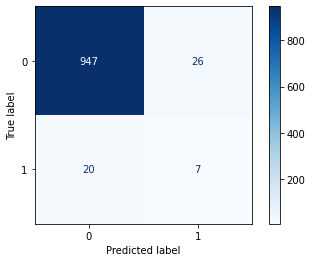

In [41]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(40,), alpha=0.01, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_20, y_train_balanced_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (30% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       973
           1       0.17      0.56      0.27        27

    accuracy                           0.92      1000
   macro avg       0.58      0.74      0.61      1000
weighted avg       0.96      0.92      0.94      1000

Confusion Matrix: 


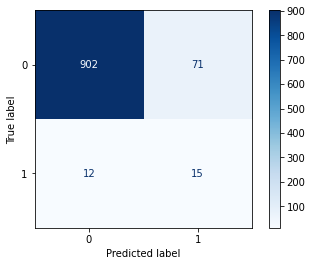

In [42]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_30_normalized, y_train_balanced_30, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.78      0.87       973
           1       0.03      0.26      0.06        27

    accuracy                           0.77      1000
   macro avg       0.50      0.52      0.46      1000
weighted avg       0.95      0.77      0.85      1000

Confusion Matrix: 


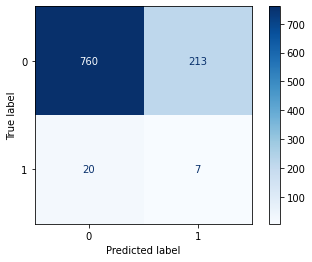

In [43]:
svm_clf = SVC(kernel='sigmoid', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_30, y_train_balanced_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       973
           1       1.00      0.15      0.26        27

    accuracy                           0.98      1000
   macro avg       0.99      0.57      0.62      1000
weighted avg       0.98      0.98      0.97      1000

Confusion Matrix: 


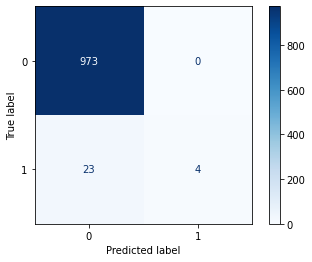

In [44]:
rf_clf = RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=60, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_30, y_train_balanced_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       973
           1       0.22      0.48      0.31        27

    accuracy                           0.94      1000
   macro avg       0.60      0.72      0.64      1000
weighted avg       0.96      0.94      0.95      1000

Confusion Matrix: 


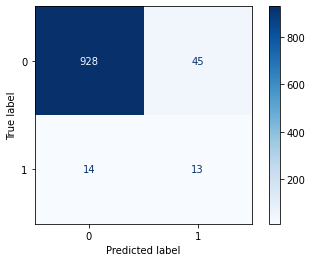

In [45]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(300,), alpha=0.1, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_30, y_train_balanced_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (40% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       973
           1       0.17      0.56      0.26        27

    accuracy                           0.92      1000
   macro avg       0.58      0.74      0.61      1000
weighted avg       0.96      0.92      0.94      1000

Confusion Matrix: 


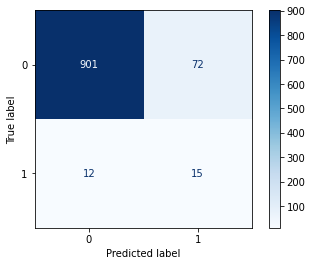

In [46]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_40_normalized, y_train_balanced_40, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       973
           1       0.15      0.15      0.15        27

    accuracy                           0.95      1000
   macro avg       0.57      0.56      0.56      1000
weighted avg       0.95      0.95      0.95      1000

Confusion Matrix: 


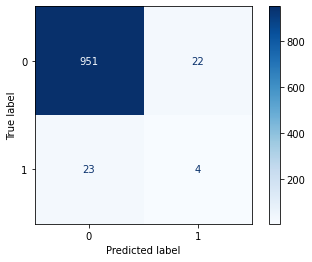

In [21]:
svm_clf = SVC(kernel='rbf', C=1000, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_40, y_train_balanced_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       973
           1       1.00      0.15      0.26        27

    accuracy                           0.98      1000
   macro avg       0.99      0.57      0.62      1000
weighted avg       0.98      0.98      0.97      1000

Confusion Matrix: 


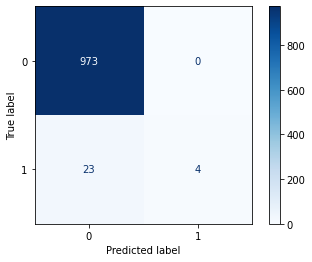

In [22]:
rf_clf = RandomForestClassifier(n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=None, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_40, y_train_balanced_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       973
           1       0.17      0.15      0.16        27

    accuracy                           0.96      1000
   macro avg       0.58      0.56      0.57      1000
weighted avg       0.95      0.96      0.96      1000

Confusion Matrix: 


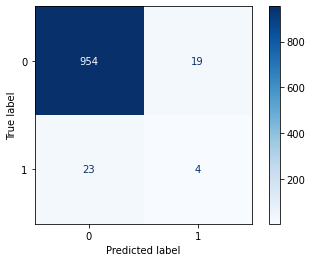

In [25]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(500,), alpha=0.01, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_40, y_train_balanced_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (50% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       973
           1       0.18      0.56      0.27        27

    accuracy                           0.92      1000
   macro avg       0.58      0.74      0.61      1000
weighted avg       0.97      0.92      0.94      1000

Confusion Matrix: 


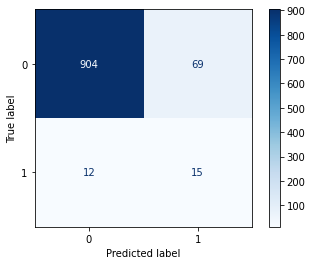

In [26]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_50_normalized, y_train_balanced_50, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       973
           1       0.05      0.63      0.10        27

    accuracy                           0.69      1000
   macro avg       0.52      0.66      0.46      1000
weighted avg       0.96      0.69      0.80      1000

Confusion Matrix: 


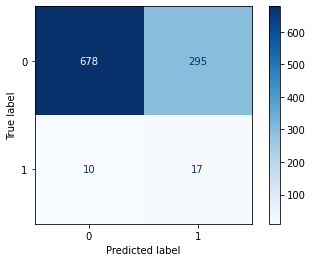

In [27]:
svm_clf = SVC(kernel='rbf', C=1000, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_50, y_train_balanced_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       973
           1       1.00      0.15      0.26        27

    accuracy                           0.98      1000
   macro avg       0.99      0.57      0.62      1000
weighted avg       0.98      0.98      0.97      1000

Confusion Matrix: 


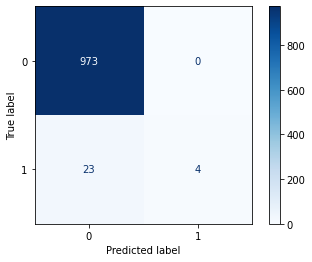

In [28]:
rf_clf = RandomForestClassifier(n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=80, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_50, y_train_balanced_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       973
           1       0.20      0.11      0.14        27

    accuracy                           0.96      1000
   macro avg       0.59      0.55      0.56      1000
weighted avg       0.95      0.96      0.96      1000

Confusion Matrix: 


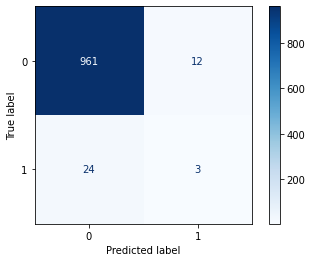

In [91]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(300,), alpha=0.0001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_50, y_train_balanced_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

#### Classification - undersampling data

##### Test Hyperparameters

PCA unbalanced (10% fraud)

In [54]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_10_normalized, y_train_balanced_us_10)
test_hyperparameters('SVM', X_train_balanced_us_10, y_train_balanced_us_10)
test_hyperparameters('Random Forest', X_train_balanced_us_10, y_train_balanced_us_10)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_10, y_train_balanced_us_10)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 1}
Best hyperparameters based on f1 score for SVM: {'kernel': 'poly', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'entropy'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (500,), 'alpha': 0.01, 'activation': 'relu'}


PCA unbalanced (20% fraud)

In [55]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_20_normalized, y_train_balanced_us_20)
test_hyperparameters('SVM', X_train_balanced_us_20, y_train_balanced_us_20)
test_hyperparameters('Random Forest', X_train_balanced_us_20, y_train_balanced_us_20)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_20, y_train_balanced_us_20)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'poly', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'entropy'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'alpha': 0.001, 'activation': 'relu'}


PCA unbalanced (30% fraud)

In [56]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_30_normalized, y_train_balanced_us_30)
test_hyperparameters('SVM', X_train_balanced_us_30, y_train_balanced_us_30)
test_hyperparameters('Random Forest', X_train_balanced_us_30, y_train_balanced_us_30)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_30, y_train_balanced_us_30)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 1}
Best hyperparameters based on f1 score for SVM: {'kernel': 'poly', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 60, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (300,), 'alpha': 0.1, 'activation': 'relu'}


PCA unbalanced (40% fraud)

In [57]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_40_normalized, y_train_balanced_us_40)
test_hyperparameters('SVM', X_train_balanced_us_40, y_train_balanced_us_40)
test_hyperparameters('Random Forest', X_train_balanced_us_40, y_train_balanced_us_40)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_40, y_train_balanced_us_40)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.1}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (40,), 'alpha': 0.1, 'activation': 'relu'}


PCA unbalanced (50% fraud)

In [58]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_50_normalized, y_train_balanced_us_50)
test_hyperparameters('SVM', X_train_balanced_us_50, y_train_balanced_us_50)
test_hyperparameters('Random Forest', X_train_balanced_us_50, y_train_balanced_us_50)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_50, y_train_balanced_us_50)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.01}
Best hyperparameters based on f1 score for SVM: {'kernel': 'poly', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (300,), 'alpha': 0.0001, 'activation': 'relu'}


##### Classificate (10% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       973
           1       0.09      0.30      0.13        27

    accuracy                           0.90      1000
   macro avg       0.53      0.60      0.54      1000
weighted avg       0.95      0.90      0.92      1000

Confusion Matrix: 


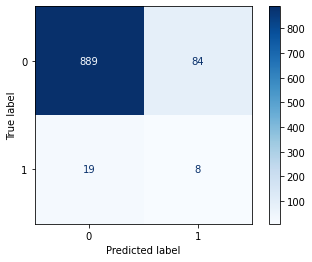

In [59]:
nb_clf = MultinomialNB(alpha=1)

y_pred = create_classifier(nb_clf, X_train_balanced_us_10_normalized, y_train_balanced_us_10, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val) 

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       973
           1       0.09      0.37      0.15        27

    accuracy                           0.88      1000
   macro avg       0.54      0.63      0.54      1000
weighted avg       0.96      0.88      0.92      1000

Confusion Matrix: 


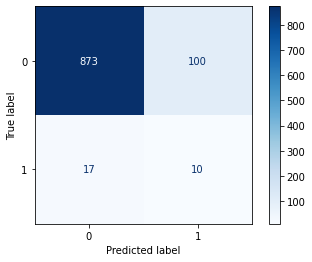

In [31]:
svm_clf = SVC(kernel='sigmoid', C=100, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_10, y_train_balanced_us_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       973
           1       0.44      0.15      0.22        27

    accuracy                           0.97      1000
   macro avg       0.71      0.57      0.60      1000
weighted avg       0.96      0.97      0.97      1000

Confusion Matrix: 


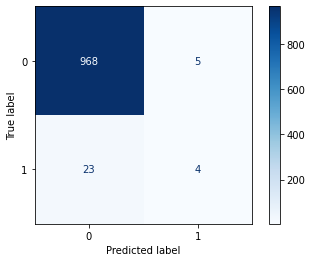

In [33]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=20, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_10, y_train_balanced_us_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       973
           1       0.14      0.07      0.10        27

    accuracy                           0.96      1000
   macro avg       0.56      0.53      0.54      1000
weighted avg       0.95      0.96      0.96      1000

Confusion Matrix: 


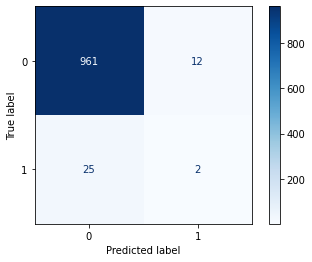

In [34]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(300,), alpha=0.0001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_10, y_train_balanced_us_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (20% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       973
           1       0.11      0.56      0.19        27

    accuracy                           0.87      1000
   macro avg       0.55      0.72      0.56      1000
weighted avg       0.96      0.87      0.91      1000

Confusion Matrix: 


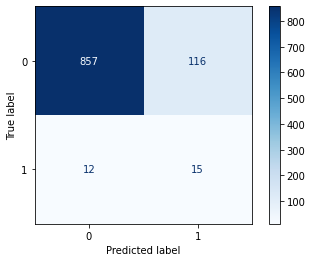

In [63]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_us_20_normalized, y_train_balanced_us_20, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.77      0.87       973
           1       0.06      0.52      0.11        27

    accuracy                           0.77      1000
   macro avg       0.52      0.65      0.49      1000
weighted avg       0.96      0.77      0.84      1000

Confusion Matrix: 


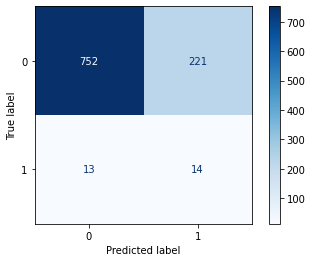

In [36]:
svm_clf = SVC(kernel='sigmoid', C=1000, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_20, y_train_balanced_us_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       973
           1       0.31      0.30      0.30        27

    accuracy                           0.96      1000
   macro avg       0.64      0.64      0.64      1000
weighted avg       0.96      0.96      0.96      1000

Confusion Matrix: 


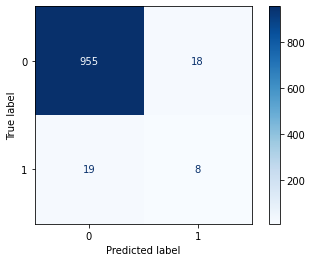

In [38]:
rf_clf = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=60, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_20, y_train_balanced_us_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       973
           1       0.12      0.26      0.16        27

    accuracy                           0.93      1000
   macro avg       0.55      0.60      0.56      1000
weighted avg       0.96      0.93      0.94      1000

Confusion Matrix: 


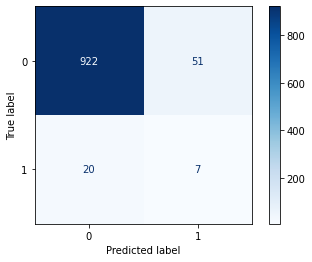

In [39]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(10,), alpha=0.001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_20, y_train_balanced_us_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (30% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       973
           1       0.09      0.37      0.14        27

    accuracy                           0.88      1000
   macro avg       0.53      0.63      0.54      1000
weighted avg       0.96      0.88      0.91      1000

Confusion Matrix: 


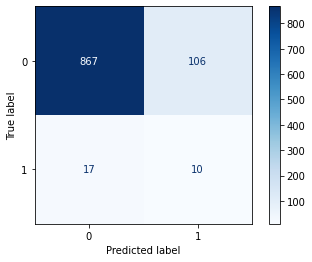

In [40]:
nb_clf = MultinomialNB(alpha=1)

y_pred = create_classifier(nb_clf, X_train_balanced_us_30_normalized, y_train_balanced_us_30, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       973
           1       0.08      0.33      0.13        27

    accuracy                           0.88      1000
   macro avg       0.53      0.62      0.54      1000
weighted avg       0.96      0.88      0.92      1000

Confusion Matrix: 


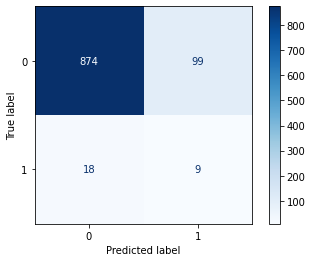

In [53]:
svm_clf = SVC(kernel='sigmoid', C=10, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_30, y_train_balanced_us_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       973
           1       0.21      0.30      0.24        27

    accuracy                           0.95      1000
   macro avg       0.59      0.63      0.61      1000
weighted avg       0.96      0.95      0.95      1000

Confusion Matrix: 


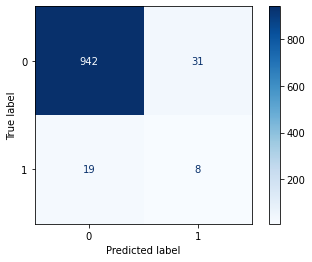

In [55]:
rf_clf = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=80, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_30, y_train_balanced_us_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       973
           1       0.11      0.26      0.15        27

    accuracy                           0.92      1000
   macro avg       0.54      0.60      0.56      1000
weighted avg       0.96      0.92      0.94      1000

Confusion Matrix: 


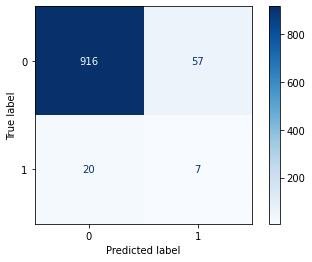

In [63]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(600,), alpha=0.1, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_30, y_train_balanced_us_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (40% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       973
           1       0.09      0.48      0.15        27

    accuracy                           0.85      1000
   macro avg       0.54      0.67      0.53      1000
weighted avg       0.96      0.85      0.90      1000

Confusion Matrix: 


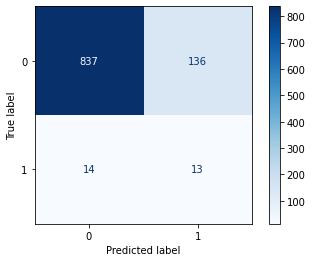

In [65]:
nb_clf = MultinomialNB(alpha=0.001)

y_pred = create_classifier(nb_clf, X_train_balanced_us_40_normalized, y_train_balanced_us_40, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.56      0.71       973
           1       0.04      0.67      0.08        27

    accuracy                           0.56      1000
   macro avg       0.51      0.61      0.39      1000
weighted avg       0.96      0.56      0.70      1000

Confusion Matrix: 


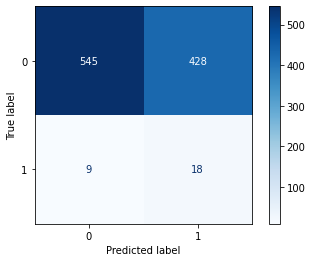

In [77]:
svm_clf = SVC(kernel='sigmoid', C=1000, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_40, y_train_balanced_us_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       973
           1       0.14      0.67      0.24        27

    accuracy                           0.88      1000
   macro avg       0.57      0.78      0.59      1000
weighted avg       0.97      0.88      0.92      1000

Confusion Matrix: 


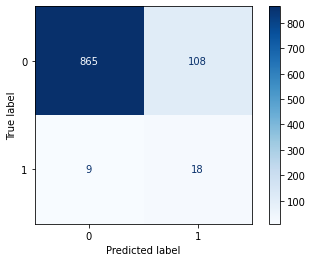

In [78]:
rf_clf = RandomForestClassifier(n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features='auto', max_depth=100, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_40, y_train_balanced_us_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       973
           1       0.09      0.48      0.15        27

    accuracy                           0.85      1000
   macro avg       0.53      0.67      0.53      1000
weighted avg       0.96      0.85      0.90      1000

Confusion Matrix: 


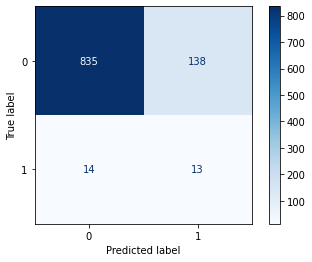

In [80]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(400,), alpha=0.001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_40, y_train_balanced_us_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (50% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       973
           1       0.08      0.48      0.14        27

    accuracy                           0.84      1000
   macro avg       0.53      0.66      0.52      1000
weighted avg       0.96      0.84      0.89      1000

Confusion Matrix: 


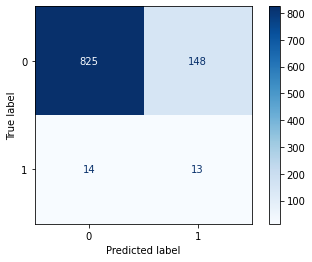

In [111]:
nb_clf = MultinomialNB(alpha=0.01)

y_pred = create_classifier(nb_clf, X_train_balanced_us_50_normalized, y_train_balanced_us_50, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.64      0.77       973
           1       0.04      0.59      0.08        27

    accuracy                           0.64      1000
   macro avg       0.51      0.61      0.43      1000
weighted avg       0.96      0.64      0.75      1000

Confusion Matrix: 


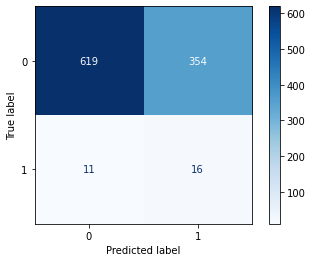

In [85]:
svm_clf = SVC(kernel='poly', C=1000, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_50, y_train_balanced_us_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       973
           1       0.10      0.70      0.18        27

    accuracy                           0.83      1000
   macro avg       0.55      0.77      0.54      1000
weighted avg       0.97      0.83      0.89      1000

Confusion Matrix: 


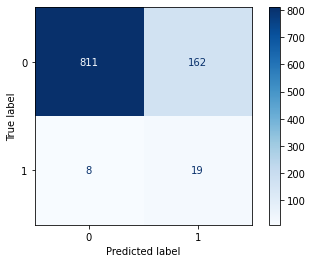

In [86]:
rf_clf = RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', max_depth=100, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_50, y_train_balanced_us_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       973
           1       0.08      0.48      0.13        27

    accuracy                           0.83      1000
   macro avg       0.53      0.66      0.52      1000
weighted avg       0.96      0.83      0.89      1000

Confusion Matrix: 


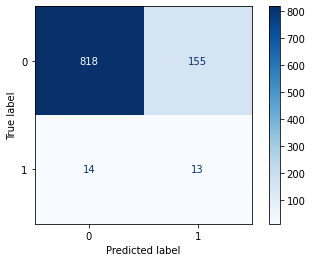

In [90]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(600,), alpha=0.001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_50, y_train_balanced_us_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

## Classification

### Balance dataset

In [15]:
X_train_balanced_20, y_train_balanced_20 = balance_dataset('oversampling', X_train, y_train, 0.251) # 20% fraud

print('20%:')
print('X_train.shape', X_train_balanced_20.shape)

20%:
X_train.shape (3685, 2263)


### Normalize data for Naive Bayes

In [16]:
scaler = MinMaxScaler()

X_train_balanced_20_normalized = scaler.fit(X_train_balanced_20).transform(X_train_balanced_20)
X_val_normalized = scaler.fit(X_val).transform(X_val)
X_test_normalized = scaler.fit(X_test).transform(X_test)

##### Test Hyperparameters

In [17]:
test_hyperparameters_grid('Naive Bayes', X_train_balanced_20_normalized, y_train_balanced_20)
test_hyperparameters_grid('SVM', X_train_balanced_20, y_train_balanced_20)
test_hyperparameters_grid('Random Forest', X_train_balanced_20, y_train_balanced_20)
test_hyperparameters_grid('Multilayer Perceptron', X_train_balanced_20, y_train_balanced_20)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'C': 1000, 'kernel': 'poly'}
Best hyperparameters based on f1 score for Random Forest: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (500,), 'learning_rate': 'constant', 'solver': 'adam'}


### Classificate

#### Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       972
           1       0.13      0.36      0.19        28

    accuracy                           0.92      1000
   macro avg       0.56      0.64      0.57      1000
weighted avg       0.96      0.92      0.93      1000

Confusion Matrix: 


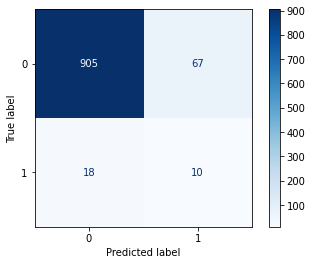

In [18]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_20_normalized, y_train_balanced_20, 
                          X_test_normalized, y_test)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_test_normalized, y_test)

#### Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       972
           1       0.33      0.04      0.06        28

    accuracy                           0.97      1000
   macro avg       0.65      0.52      0.52      1000
weighted avg       0.96      0.97      0.96      1000

Confusion Matrix: 


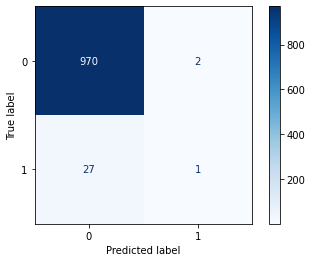

In [23]:
svm_clf = SVC(kernel='poly', C=1000, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_20, y_train_balanced_20, 
                          X_test, y_test)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_test, y_test)

#### Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       972
           1       1.00      0.25      0.40        28

    accuracy                           0.98      1000
   macro avg       0.99      0.62      0.69      1000
weighted avg       0.98      0.98      0.97      1000

Confusion Matrix: 


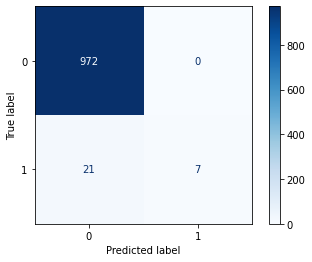

In [20]:
rf_clf = RandomForestClassifier(criterion='gini', max_depth=40, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_20, y_train_balanced_20, 
                          X_test, y_test)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_test, y_test)

#### Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       972
           1       0.33      0.14      0.20        28

    accuracy                           0.97      1000
   macro avg       0.65      0.57      0.59      1000
weighted avg       0.96      0.97      0.96      1000

Confusion Matrix: 


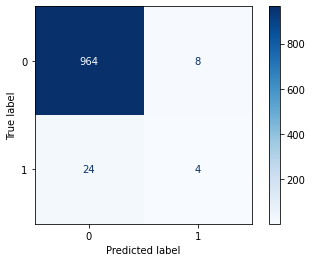

In [22]:
mlp_clf = MLPClassifier(activation='relu', alpha=1, hidden_layer_sizes=(500,), learning_rate='constant', solver='adam', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_20, y_train_balanced_20, 
                          X_test, y_test)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_test, y_test)